In [1]:
%reset -f

In [2]:
import numpy                 as np
import matplotlib.pyplot     as plt
import pandas                as pd
import statsmodels.api       as sm
import statsmodels.stats.api as sms
import numpy.linalg          as la

from statsmodels.iolib.summary2 import summary_col
from statsmodels.compat         import lzip
from scipy                      import stats

In [3]:
df = pd.read_csv("HPRICE3.csv")

In [4]:
df = sm.add_constant(df)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [5]:
df.columns

Index(['const', 'year', 'age', 'agesq', 'nbh', 'cbd', 'inst', 'linst', 'price',
       'rooms', 'area', 'land', 'baths', 'dist', 'ldist', 'lprice', 'y81',
       'larea', 'lland', 'linstsq'],
      dtype='object')

# select the data with year = 1978 only

In [6]:
df = df[df['year']==1978]

# (a)

In [7]:
df.describe()

,const,year,age,agesq,nbh,cbd,inst,linst,price,rooms,area,land,baths,dist,ldist,lprice,y81,larea,lland,linstsq
count,179.0,179.0,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.0,179.000000,179.000000,179.000000
mean,1.0,1978.0,21.206704,1871.206704,2.402235,16424.581006,17128.491620,9.504069,76628.039106,6.581006,1999.636872,42955.474860,2.307263,21195.530726,9.853867,11.179079,0.0,7.550936,10.320077,90.999762
std,0.0,0.0,37.808310,6063.715230,2.126662,9411.244722,9425.653702,0.822324,30626.444888,0.958626,635.007659,50258.054117,0.742379,8849.756051,0.497732,0.366974,0.0,0.320571,0.862318,14.828158
min,1.0,1978.0,0.000000,0.000000,0.000000,1000.000000,1000.000000,6.907800,26000.000000,4.000000,750.000000,1710.000000,1.000000,5200.000000,8.556414,10.165852,0.0,6.620073,7.444249,47.717705
25%,1.0,1978.0,0.000000,0.000000,0.000000,7000.000000,7500.000000,8.920450,56450.000000,6.000000,1495.000000,15547.500000,2.000000,13450.000000,9.506727,10.941079,0.0,7.309876,9.651627,79.578880
50%,1.0,1978.0,5.000000,25.000000,2.000000,17000.000000,17000.000000,9.741000,75500.000000,7.000000,1998.000000,43663.000000,2.000000,21000.000000,9.952278,11.231888,0.0,7.599902,10.684257,94.887085
75%,1.0,1978.0,23.000000,529.000000,4.000000,24000.000000,26000.000000,10.166000,90200.000000,7.000000,2392.000000,46174.000000,3.000000,28050.000000,10.241740,11.409783,0.0,7.779880,10.740172,103.347560
max,1.0,1978.0,189.000000,35721.000000,6.000000,35000.000000,34000.000000,10.434000,300000.000000,10.000000,5078.000000,544500.000000,4.000000,40000.000000,10.596630,12.611538,0.0,8.532673,13.207623,108.868350


# (c)

## generate $\log \left(cbd\right)$

In [8]:
df['lcbd'] = np.log(df.cbd)

## run regression model (1)

In [9]:
x = df[['const','rooms', 'baths', 'larea', 'lland', 'age', 'agesq', 'lcbd']]
y = df[['lprice']]
M1 = sm.OLS(y,x)
M1_result = M1.fit()
print(M1_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     51.59
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           5.78e-39
Time:                        10:03:21   Log-Likelihood:                 27.555
No. Observations:                 179   AIC:                            -39.11
Df Residuals:                     171   BIC:                            -13.61
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3668      0.557     13.218      0.0

## compute percentage change

In [10]:
percentage_change = 100*(np.exp(M1_result.params[2])-1)
print('percentage change :', percentage_change)

percentage change : 6.812621026421128


## compare the percentage with $100 \cdot \beta_2$

In [11]:
print('ratio of approximation to the orginal value :', percentage_change/(M1_result.params[2]*100))

ratio of approximation to the orginal value : 1.033688972237307


# (d) calculate $95\%$ CI

In [12]:
M1_result.conf_int(alpha=0.05)

,0,1
const,6.266710,8.466987
rooms,0.018050,0.105973
baths,-0.008349,0.140161
larea,0.234620,0.524603
lland,0.041274,0.170858
age,-0.012022,-0.004359
agesq,0.000014,0.000058
lcbd,-0.137424,0.009903


# (e)
## $$H_0 : \beta_7 \geqslant 0$$
## $$H_1 : \beta_7 < 0$$

## the t-statistic can be directly extracted from the table
## we just need to compute the left-tail p-value

In [13]:
p_left = 1 - stats.t.sf(M1_result.tvalues[7], M1_result.df_resid)

sig_level = 0.1

print("the t-value of beta_baths :", M1_result.tvalues[7])
print("the significant level :", sig_level)
print("the left-tail p-value of beta_baths :", p_left)

if p_left > sig_level:
    print("fail to reject H0 since p value is larger than sig level")
else:
    print("reject H0 since p value is smaller than significant level")

the t-value of beta_baths : -1.7085757694225632
the significant level : 0.1
the left-tail p-value of beta_baths : 0.04467198870754807
reject H0 since p value is smaller than significant level


# (f): minimize predicted log(price) on the value of "age"

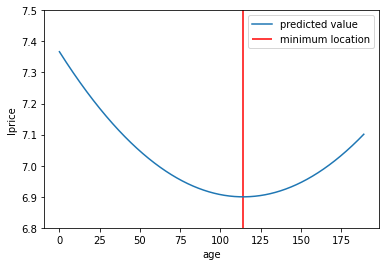

the minimum is obtained at age= 114.0755204368843


In [14]:
fig1 = plt.figure()

X_plot  = np.arange(df['age'].min(), df['age'].max(),0.01)
X2_plot = np.square(X_plot)

Y_plot  = M1_result.params[0] + M1_result.params[5] * X_plot + M1_result.params[6] * X2_plot

sym_ax  = -1 * M1_result.params[5] / (2*M1_result.params[6])

plt.plot(X_plot, Y_plot, label='predicted value')
plt.vlines(sym_ax, 0, 10, colors='r', label='minimum location')
plt.ylim(6.8,7.5)

plt.legend()
plt.xlabel("age")
plt.ylabel("lprice")
plt.show()

print("the minimum is obtained at age=",sym_ax)

# (g) : F-test age and agesq

In [15]:
M1_result.f_test('age=agesq=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[14.84102778]]), p=1.1394288247698759e-06, df_denom=171, df_num=2>

# (h) BP test
## BP test can be doon using LM statistic or F-statistics; hence, you have both reported here

In [16]:
result1 = sms.het_breuschpagan(M1_result.resid, M1_result.model.exog)
out =['LM stat:', 'LM p-value:', 'F stat:', 'F p-value:']
lzip(out,result1)

[('LM stat:', 5.714027898513024),
 ('LM p-value:', 0.5735090639554246),
 ('F stat:', 0.80552128352274),
 ('F p-value:', 0.5837672566895304)]

# (i) 

## regression with lcbd dropped

In [17]:
x_2 = df[['const','rooms', 'baths', 'larea', 'lland', 'age', 'agesq']]
y_2 = df[['lprice']]
M2 = sm.OLS(y_2,x_2)
M2_result = M2.fit()
print(M2_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     59.04
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           3.00e-39
Time:                        10:03:26   Log-Likelihood:                 26.040
No. Observations:                 179   AIC:                            -38.08
Df Residuals:                     172   BIC:                            -15.77
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0572      0.530     13.316      0.0

## compare the models with and without lcbd

In [18]:
summary = summary_col(
    [M1_result,M2_result], stars=True, float_format='%0.4f',
    model_names=['with','without'],
    info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
               'R2':lambda x: "{:.2f}".format(x.rsquared),
               'AIC':lambda x: "{:.2f}".format(x.aic),
               'BIC':lambda x: "{:.2f}".format(x.bic)})
print(summary)


                  with     without  
------------------------------------
R-squared      0.6786     0.6732    
R-squared Adj. 0.6655     0.6618    
age            -0.0082*** -0.0067***
               (0.0019)   (0.0017)  
agesq          0.0000***  0.0000*** 
               (0.0000)   (0.0000)  
baths          0.0659*    0.0735*   
               (0.0376)   (0.0376)  
const          7.3668***  7.0572*** 
               (0.5573)   (0.5300)  
larea          0.3796***  0.3891*** 
               (0.0735)   (0.0737)  
lcbd           -0.0638*             
               (0.0373)             
lland          0.1061***  0.0702*** 
               (0.0328)   (0.0254)  
rooms          0.0620***  0.0576**  
               (0.0223)   (0.0222)  
N              179        179       
R2             0.68       0.67      
AIC            -39.11     -38.08    
BIC            -13.61     -15.77    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## let's check whether two models are different in population using Hausman test

## $$H_0: \mbox{both models are identical in population}$$
## $$H_1: H_0 \mbox{ is wrong}$$

In [19]:
b = M1_result.params[0:7]
print(b)

const    7.366848
rooms    0.062012
baths    0.065906
larea    0.379611
lland    0.106066
age     -0.008190
agesq    0.000036
dtype: float64


In [20]:
B = M2_result.params[0:7]
print(B)

const    7.057240
rooms    0.057632
baths    0.073534
larea    0.389071
lland    0.070169
age     -0.006665
agesq    0.000028
dtype: float64


In [21]:
v_b = M1_result.cov_params().drop(['lcbd'], axis=1)
v_b = v_b.drop(['lcbd'], axis=0)
print(v_b)

          const         rooms         baths         larea         lland  \
const  0.310620 -2.143676e-04  9.339416e-03 -3.384812e-02 -7.643452e-04   
rooms -0.000214  4.960015e-04 -2.763710e-04 -2.087286e-04  9.545166e-06   
baths  0.009339 -2.763710e-04  1.415097e-03 -1.505229e-03 -1.282565e-04   
larea -0.033848 -2.087286e-04 -1.505229e-03  5.395343e-03 -3.638468e-04   
lland -0.000764  9.545166e-06 -1.282565e-04 -3.638468e-04  1.077395e-03   
age   -0.000336  3.666034e-07  2.724432e-05 -1.510242e-05  2.887817e-06   
agesq  0.000002 -2.055265e-08 -1.325309e-07  4.155316e-08 -1.446064e-08   

                age         agesq  
const -3.362186e-04  2.132895e-06  
rooms  3.666034e-07 -2.055265e-08  
baths  2.724432e-05 -1.325309e-07  
larea -1.510242e-05  4.155316e-08  
lland  2.887817e-06 -1.446064e-08  
age    3.767603e-06 -2.107937e-08  
agesq -2.107937e-08  1.262314e-10  


In [22]:
v_B = M2_result.cov_params()
print(v_B)

          const         rooms         baths         larea         lland  \
const  0.280883 -6.864694e-04  1.026163e-02 -3.321129e-02 -4.622557e-03   
rooms -0.000686  4.948912e-04 -2.678829e-04 -1.967057e-04 -4.480846e-05   
baths  0.010262 -2.678829e-04  1.410735e-03 -1.547019e-03 -3.484550e-05   
larea -0.033211 -1.967057e-04 -1.547019e-03  5.424547e-03 -2.502799e-04   
lland -0.004623 -4.480846e-05 -3.484550e-05 -2.502799e-04  6.430683e-04   
age   -0.000176  2.684370e-06  2.351906e-05 -2.026818e-05  2.188264e-05   
agesq  0.000001 -3.287917e-08 -1.129425e-07  6.814518e-08 -1.137691e-07   

                age         agesq  
const -1.764209e-04  1.301568e-06  
rooms  2.684370e-06 -3.287917e-08  
baths  2.351906e-05 -1.129425e-07  
larea -2.026818e-05  6.814518e-08  
lland  2.188264e-05 -1.137691e-07  
age    3.004039e-06 -1.710243e-08  
agesq -1.710243e-08  1.056164e-10  


In [23]:
df_t = 1
chi2 = np.dot((b-B).T, la.inv(v_b - v_B).dot(b - B)) 

pval = stats.chi2.sf(chi2, df_t)


dict = {'chi-sq stat' : [chi2],
        'df' : [df_t],
        'p-value' : [pval]}
Hausman_df = pd.DataFrame(dict)
Hausman_df.round(2)

,chi-sq stat,df,p-value
0,2.92,1,0.09


## the p-value is larger than 0.05 and 0.01; hence we cannot reject $H_0$

# (j) model the bedroom size as well
## there are different way to do this; I will do it by including 

## $$larea \times room$$

In [24]:
df['area_rooms'] = df.larea * df.rooms

In [25]:
x_3 = df[['const','rooms', 'baths', 'larea', 'lland', 'age', 'agesq', 'lcbd', 'area_rooms']]
y_3 = df[['lprice']]
M3 = sm.OLS(y_3,x_3)
M3_result = M3.fit()
print(M3_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 lprice   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     49.13
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           2.34e-40
Time:                        10:03:31   Log-Likelihood:                 33.136
No. Observations:                 179   AIC:                            -48.27
Df Residuals:                     170   BIC:                            -19.58
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7275      1.998      6.870      0.0

In [26]:
summary = summary_col(
    [M1_result,M2_result,M3_result], stars=True, float_format='%0.4f',
    model_names=['Q(c)','Q(i)','Q(j)'],
    info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
               'R2':lambda x: "{:.2f}".format(x.rsquared),
               'AIC':lambda x: "{:.2f}".format(x.aic),
               'BIC':lambda x: "{:.2f}".format(x.bic)})
print(summary)


                  Q(c)       Q(i)       Q(j)   
-----------------------------------------------
R-squared      0.6786     0.6732     0.6981    
R-squared Adj. 0.6655     0.6618     0.6839    
age            -0.0082*** -0.0067*** -0.0080***
               (0.0019)   (0.0017)   (0.0019)  
agesq          0.0000***  0.0000***  0.0000*** 
               (0.0000)   (0.0000)   (0.0000)  
area_rooms                           0.1358*** 
                                     (0.0411)  
baths          0.0659*    0.0735*    0.0539    
               (0.0376)   (0.0376)   (0.0368)  
const          7.3668***  7.0572***  13.7275***
               (0.5573)   (0.5300)   (1.9981)  
larea          0.3796***  0.3891***  -0.4758*  
               (0.0735)   (0.0737)   (0.2683)  
lcbd           -0.0638*              -0.0553   
               (0.0373)              (0.0364)  
lland          0.1061***  0.0702***  0.1005*** 
               (0.0328)   (0.0254)   (0.0320)  
rooms          0.0620***  0.0576**   -0

In [27]:
!rm -rf Python_21S2.html
!jupyter nbconvert --to html Python_21S2.ipynb

[NbConvertApp] Converting notebook Python_21S2.ipynb to html
[NbConvertApp] Writing 645467 bytes to Python_21S2.html
